In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications import VGG16
from keras.preprocessing import image
import keras
from keras import layers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import optimizers
import scipy.io
import numpy as np
import os
import random
%matplotlib inline
import matplotlib.pyplot as plt
from vgg import myVGG16


Using TensorFlow backend.


In [2]:
# setting
num_of_class = 3
crop_size = 224
data_dir = './start/'
shuffle = True

## Utils

In [3]:
def original(img):
    tmp = np.zeros_like(img)
    for i in range(3):
        tmp[:,:,i] = img[:,:,i] - img[:,:,i].min()
    return tmp.astype(np.uint8)

def lookup(d, key, i):
    if key == 'make+model':
        for item in d:
            if item['pp_brand_id']+' '+item['pp_genre_id'] == i:
                return item
    else:
        for item in d:
            if item[key] == i:
                return item

## Loading data

In [4]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras.applications.imagenet_utils import preprocess_input
import glob

def load_data(image_paths, labels, crop_size):
    """
    Given list of paths, load images as one numpy array of shape
        (num_images, crop_size, crop_size, channel)
    :return X: image array
    "return y: one hot encoded labels
    """
    X = np.zeros((len(image_paths), crop_size, crop_size, 3))
    for i,path in enumerate(image_paths):
        X[i, :] = img_to_array(load_img(path, target_size=(crop_size, crop_size)))
    y = np_utils.to_categorical(labels, num_of_class)
    return X, y

train_paths = []
val_paths = []
val_paths = []
test_paths = []
train_labels = []
val_labels = []
test_labels = []
train_makes = []

# indentify make/model/car_id.jpg
makes = os.listdir(data_dir)
makes.remove('bba')
for make in makes:
    models = os.listdir(os.path.join(data_dir, make))
    for model in models:
        #pics = glob.glob(os.path.join(data_dir, make, model))
        pics = glob.glob(os.path.join(data_dir, make, model)+'/*_b.jpg')
        if len(pics) < 10:
            continue
        print (len(pics))
        for pic in pics[:80]:
            # two pic in a row
            train_paths += [pic[:-6] + '.jpg' + ' ' + pic]
            # label|
            train_makes += [make + ' ' +model]
            #train_makes += [make]

num_of_inst = len(train_makes)
assert(len(train_makes) == len(train_paths))

l2i = sorted(list(set(train_makes)))
# convert string 2 class num
for item in train_makes:
    train_labels.append(l2i.index(item))

if shuffle == True :
    idx = list(range(len(train_labels)))
    random.shuffle (idx)
    train_labels = np.array(train_labels)
    train_paths = np.array(train_paths)
    train_labels = train_labels[idx]
    train_paths = train_paths[idx]

train_labels = list(train_labels)
train_paths = list(train_paths)


split = int(num_of_inst*3/4)
val_labels = train_labels[split:]
val_paths = train_paths[split:]
train_labels = train_labels[:split]
train_paths = train_paths[:split]
num_of_class = len(l2i)
print (l2i)

76
64
10
266
214
308
254
185
100
21
34
22
49
66
200
337
35
101
215
22
43
20
48
35
18
19
50
218
223
42
38
22
198
403
100
100
39
163
230
219
430
14
49
23
74
174
20
10
12
40
33
327
19
36
54
135
68
19
13
170
13
25
33
16
11
135
77
16
23
10
125
25
40
27
550
219
16
193
134
18
27
23
18
297
13
46
220
53
24
13
11
43
430
220
24
51
179
292
183
74
132
10
22
150
41
257
46
13
560
171
183
511
15
153
10
13
19
28
183
73
12
28
10
['1 1', '1 1135', '1 1218', '1 16', '1 17', '1 20', '1 20010', '1 22', '1 2434', '1 2459', '1 2472', '1 416', '1 426', '1 47', '1 48', '1 49', '1 50', '1 51', '1 52', '1 54', '1 57', '11 169', '11 20023', '11 20024', '11 20136', '11 37', '11 84', '11 989', '11 990', '12 1221', '12 1224', '12 20003', '12 2458', '12 55', '12 56', '12 58', '12 59', '12 60', '12 61', '12 63', '12 64', '12 67', '13 1025', '13 1331', '13 1332', '13 209', '13 2574', '13 2575', '13 344', '13 355', '13 376', '13 81', '13 82', '13 976', '15 20025', '15 20026', '15 20027', '15 472', '15 482', '15 90', '15 

In [5]:
len(train_labels)

4535

In [6]:
#X_val, y_val = load_data(val_paths, val_labels, crop_size)

front_path = [p.split(' ')[0] for p in val_paths]
back_path = [p.split(' ')[1] for p in val_paths]
tmp1, y_test = load_data(front_path, val_labels, crop_size)
tmp2,_ = load_data(back_path, val_labels, crop_size)
#X_val = preprocess_input(X_val)
tmp1 = preprocess_input(tmp1)
tmp2 = preprocess_input(tmp2)
X_test = [tmp1, tmp2]


## model config

In [11]:
from keras.callbacks import ModelCheckpoint
def generate_arrays(batch_size, crop_size = 224, num_image_input=1):
    sample_number = len(train_paths)
    front_path = [p.split(' ')[0] for p in train_paths]
    back_path = [p.split(' ')[1] for p in train_paths]
    if num_image_input == 1:
        while True:
            for i in range(0,sample_number,batch_size):
                if i + batch_size > sample_number:
                    X_train, y_train = load_data(front_path[i:], train_labels[i:], crop_size)
                    X_train = preprocess_input(X_train)
                else:
                    X_train, y_train = load_data(front_path[i:i+batch_size], train_labels[i:i+batch_size], crop_size)
                    X_train = preprocess_input(X_train)
                yield X_train, y_train
    else:
        while True:
            for i in range(0,sample_number,batch_size):
                if i + batch_size > sample_number:
                    X_train, y_train = load_data(front_path[i:], train_labels[i:], crop_size)
                    X_train2, y_train2 = load_data(back_path[i:], train_labels[i:], crop_size)
                else:
                    X_train, y_train = load_data(front_path[i:i+batch_size], train_labels[i:i+batch_size], crop_size)
                    X_train2, y_train2 = load_data(back_path[i:i+batch_size], train_labels[i:i+batch_size], crop_size)
                X_train = preprocess_input(X_train)
                X_train2 = preprocess_input(X_train2)
                yield ([X_train, X_train2], y_train)
checkpointer = ModelCheckpoint(filepath='./model/80PERCLASS.{epoch:02d}-{val_loss:.2f}.hdf5', period = 5)

## Build Model

In [8]:
def get_model( output_dim ):
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(4096, activation='relu')(x)
    # and a logistic layer|
    predictions = Dense(output_dim, activation='softmax')(x)
    model = Model(input=base_model.input, output=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model
def get_model2( output_dim ):
    vgg_model = myVGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.layers[-2].output #Last FC layer's output 
    softmax_layer = Dense(output_dim=output_dim, activation='softmax')(vgg_out)
    #Create new transfer learning model
    tl_model = Model( input=vgg_model.input, output=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in vgg_model.layers[:-2]:
        layer.trainable = False
    #Confirm the model is appropriate
    #tl_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    #tl_model.summary()
    return tl_model

In [9]:
def get_model3( output_dim):
    #Two vgg model. One for front pic One for back pic
    front_model = myVGG16( weights='imagenet', include_top=True ,appendix = 'f')
    back_model = myVGG16( weights='imagenet', include_top=True ,appendix = 'b')
    #Last FC layer's output 
    front_f = front_model.layers[-2].output 
    back_f = back_model.layers[-2].output
    #Concatenate two layers
    merged = layers.Concatenate()([front_f, back_f])
    
    softmax_layer = Dense(units=output_dim, activation='softmax')(merged)
    #Create new transfer learning model
    tl_model = Model( inputs=[front_model.input, back_model.input], outputs=softmax_layer )

    #Freeze all layers of VGG16 and Compile the model
    for layer in front_model.layers[:-2]:
        layer.trainable = False
    for layer in back_model.layers[:-2]:
        layer.trainable = False
    #Confirm the model is appropriate
    #tl_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    #tl_model.summary()
    return tl_model


## training

In [10]:
model = get_model3(num_of_class)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1f (Conv2D)           (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1b (Conv2D)           (None, 224, 224, 64)  1792        input_2[0][0]                    
___________________________________________________________________________________________

In [12]:

model.compile(optimizer=optimizers.RMSprop(lr=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy',metrics=['accuracy'],
#              optimizer=optimizers.SGD(lr=0.0001 , momentum=0.9, nesterov=True))
model.fit_generator(generate_arrays(batch_size=32,crop_size=224, num_image_input=2),
                    validation_data=(X_test, y_test),
                    steps_per_epoch=len(train_labels) / 32, epochs=50,
                   callbacks=[checkpointer])

Epoch 1/50
142/141 [==============================] - 201s - loss: 4.1048 - acc: 0.1342 - val_loss: 3.3411 - val_acc: 0.2216
Epoch 2/50
142/141 [==============================] - 148s - loss: 1.5420 - acc: 0.6282 - val_loss: 2.8955 - val_acc: 0.3102
Epoch 3/50
142/141 [==============================] - 147s - loss: 0.5459 - acc: 0.8912 - val_loss: 2.6769 - val_acc: 0.3730
Epoch 4/50
142/141 [==============================] - 148s - loss: 0.1981 - acc: 0.9743 - val_loss: 2.5756 - val_acc: 0.4074
Epoch 5/50
142/141 [==============================] - 156s - loss: 0.1209 - acc: 0.9791 - val_loss: 2.5592 - val_acc: 0.4352
Epoch 6/50
142/141 [==============================] - 147s - loss: 0.0996 - acc: 0.9828 - val_loss: 2.6137 - val_acc: 0.4266
Epoch 7/50
142/141 [==============================] - 150s - loss: 0.0617 - acc: 0.9877 - val_loss: 3.7812 - val_acc: 0.3036
Epoch 8/50
142/141 [==============================] - 147s - loss: 0.0695 - acc: 0.9870 - val_loss: 2.8507 - val_acc: 0.4332


KeyboardInterrupt: 

## Predict

In [8]:
# load json
# 11 audi 15 bmw 48 benz

import json
bba_info = [json.loads(line) for line in open('./start/bba/10car.json')]
bba_info[1089]

{'car_id': '782738',
 'chinese': '奔驰',
 'left_behind': '170417b7e5d85461',
 'left_front': '170470b7441b9e31',
 'pp_brand_id': '48',
 'pp_genre_id': '20060'}

In [9]:
#load model
from keras.models import load_model
model = load_model('./model/test.09-1.25.hdf5')


In [10]:
pred = model.predict(X_test)

{'pp_brand_id': '15', 'left_behind': '150413ec9b0cb1c1', 'chinese': '宝马', 'left_front': '150472fecf235c51', 'car_id': '392297', 'pp_genre_id': '20027'} 5 [  8.50149945e-07   1.63465029e-06   3.51490456e-07   7.02477280e-07
   8.83728148e-08   9.99990225e-01   8.00415467e-09   5.44063050e-06
   6.74252703e-07]


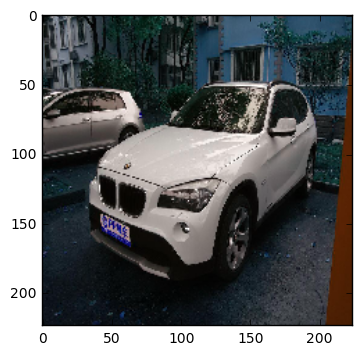

In [17]:
i = 10
print(lookup(bba_info, 'make+model', str(l2i[pred[i].argmax()])),y_test[i].argmax(),pred[i])

#print(lookup(bba_info, 'pp_brand_id', str(l2i[pred[i].argmax()])),y_test[i].argmax(),pred[i])

plt.imshow(original(X_test[0][i]))


In [77]:
for i in range(100):
    print (i, pred[i].argmax(), y_test[i].argmax())

0 92 117
1 98 98
2 39 55
3 83 95
4 91 91
5 111 106
6 75 75
7 75 75
8 75 69
9 22 14
10 91 91
11 22 109
12 96 76
13 75 75
14 63 63
15 98 98
16 95 95
17 95 95
18 39 91
19 96 96
20 96 96
21 80 80
22 83 92
23 95 95
24 80 80
25 75 111
26 98 98
27 75 75
28 55 55
29 82 82
30 23 103
31 23 23
32 96 96
33 96 96
34 80 83
35 91 91
36 98 98
37 75 75
38 95 95
39 40 40
40 96 96
41 76 68
42 39 83
43 83 91
44 23 112
45 23 23
46 95 92
47 68 98
48 76 77
49 75 75
50 92 92
51 75 75
52 80 80
53 92 98
54 83 83
55 22 22
56 40 39
57 75 75
58 39 111
59 40 39
60 23 104
61 91 111
62 68 64
63 95 95
64 75 63
65 96 96
66 80 75
67 68 68
68 98 98
69 41 41
70 76 67
71 80 80
72 95 95
73 91 81
74 68 22
75 91 83
76 96 96
77 23 55
78 112 75
79 75 117
80 75 75
81 90 91
82 40 40
83 91 8
84 68 75
85 91 112
86 75 75
87 18 18
88 22 1
89 92 80
90 75 75
91 76 76
92 91 91
93 83 83
94 98 98
95 91 98
96 91 28
97 23 23
98 22 8
99 94 94


In [50]:
tmp = load_data(['./asv/2573.jpg'],1,224)[0]
tmp = preprocess_input(tmp)
model.predict(tmp)

array([[  9.99997020e-01,   1.37746713e-06,   1.57065983e-06]], dtype=float32)

In [109]:
plt.imshow(original(tmp[0]))

NameError: name 'tmp' is not defined